In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [42]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [43]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=1000,
                                          shuffle=True)

In [44]:
dataiter = iter(data_loader)
images, labels = next(dataiter)  # Use next() directly
print(torch.min(images), torch.max(images))


tensor(0.) tensor(1.)


In [45]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [46]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [47]:
# Point to training loop video
num_epochs = 100
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0709
Epoch:2, Loss:0.0652
Epoch:3, Loss:0.0553
Epoch:4, Loss:0.0327
Epoch:5, Loss:0.0212
Epoch:6, Loss:0.0147
Epoch:7, Loss:0.0125
Epoch:8, Loss:0.0105
Epoch:9, Loss:0.0093
Epoch:10, Loss:0.0083
Epoch:11, Loss:0.0075
Epoch:12, Loss:0.0072
Epoch:13, Loss:0.0068
Epoch:14, Loss:0.0062
Epoch:15, Loss:0.0057
Epoch:16, Loss:0.0057
Epoch:17, Loss:0.0054
Epoch:18, Loss:0.0050
Epoch:19, Loss:0.0049
Epoch:20, Loss:0.0047


KeyboardInterrupt: 

Length of outputs: 20


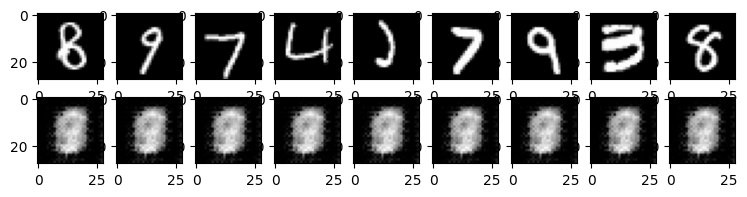

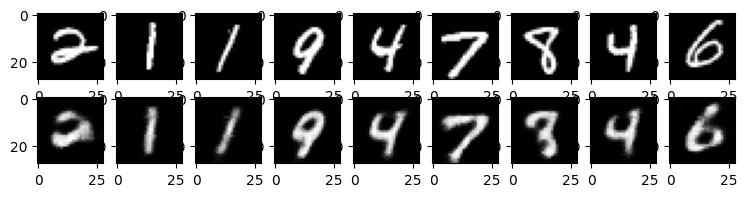

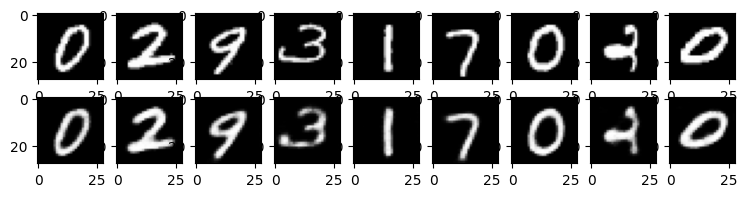

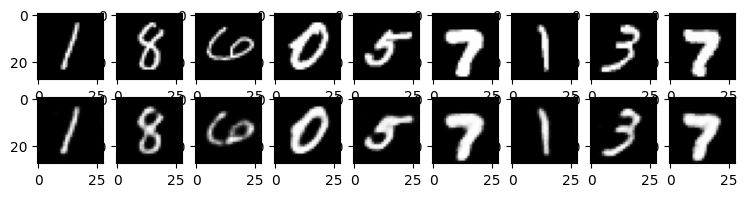

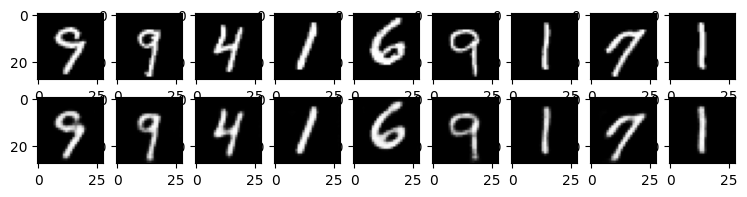

IndexError: list index out of range

<Figure size 900x200 with 0 Axes>

In [49]:
# Check the length of outputs to ensure it matches num_epochs
print("Length of outputs:", len(outputs))

# # Optionally print the structure of outputs[k] to ensure it has the expected elements
# for k in range(num_epochs):
#     print(f"outputs[{k}]:", outputs[k])

# Ensure that outputs[k] has the expected format
# If everything is correct, you can proceed with the original code
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()  # Adjust here if structure is different
    recon = outputs[k][2].detach().numpy()  # Adjust here if structure is different
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)  # -> use for Autoencoder_Linear
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28, 28)  # -> use for Autoencoder_Linear
        plt.imshow(item[0])

    plt.show()
    plt.close()


In [37]:
batch_size = 9
num_epochs = 100
outputs = []

for epoch in range(num_epochs):
    # Process in batches of size 9
    for i in range(0, x_train.shape[0]//100, batch_size):
        # Select a batch of images
        img_batch = torch.FloatTensor(x_train[i:i+batch_size])
        
        # Forward pass
        recon_batch = model(img_batch)
        loss = criterion(recon_batch, img_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch + 1}, Loss: {loss.item():.4f}")
    
    # Store the batch of images and reconstructions for visualization
    outputs.append((epoch, img_batch.detach(), recon_batch.detach()))

### Plotting
for k in range(0, num_epochs, 4):  # Show every 4th epoch
    plt.figure(figsize=(9, 2))
    plt.gray()

    # Extract original images and reconstructions from outputs
    imgs = outputs[k][1].numpy().reshape(-1, 28, 28)
    recon = outputs[k][2].numpy().reshape(-1, 28, 28)
    
    # Display original images
    for i in range(9):  # Plot up to 9 images
        plt.subplot(2, 9, i + 1)
        plt.imshow(imgs[i], cmap="gray")
        plt.axis('off')
    
    # Display reconstructed images
    for i in range(9):  # Plot up to 9 reconstructions
        plt.subplot(2, 9, 9 + i + 1)
        plt.imshow(recon[i], cmap="gray")
        plt.axis('off')

    plt.show()
    plt.close()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [9, 784]